# Bidirectional LSTM Sentiment Classifier

In this notebook, we use a *bidirectional* LSTM to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt

#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/biLSTM'

# training:
epochs = 6
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
# Note, we have doubled the value of max_review_length
# because with LSTM we can backpropagate about 100 steps, with bidirectional LSTM it is doubled
# means we can go both forward and backward over time steps - so we can doube movie_review_length.
max_review_length = 200 # doubled!
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# LSTM layer architecture:
n_lstm = 256 
drop_lstm = 0.2

#### Load data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

#### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [5]:
model = Sequential()

# First Hidden Layer - embeddings
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))

# Second Hidden layer - Bidirectional LSTM
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))

# Output Layer:
model.add(Dense(1, activation='sigmoid'))

/Users/sshivagangeprakash/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### Configure model

In [6]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [7]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.keras")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [8]:
# - with this toy dataset, the complex interplay of words over long sentence segments, won't be learned much
# - so our CNN picking up location-invariant segments of two to four words that predict review sentiment
# - these are simpler and so easier to learn from the data
# - CNN therefore outperforms on the IMDB data set
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/6
196/196 ━━━━━━━━━━━━━━━━━━━━ 174s 884ms/step - accuracy: 0.6563 - loss: 0.6016 - val_accuracy: 0.8511 - val_loss: 0.4487
Epoch 2/6
196/196 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8850 - loss: 0.2909 - val_accuracy: 0.8628 - val_loss: 0.3646
Epoch 3/6
196/196 ━━━━━━━━━━━━━━━━━━━━ 185s 943ms/step - accuracy: 0.9214 - loss: 0.2108 - val_accuracy: 0.8700 - val_loss: 0.3195
Epoch 4/6
196/196 ━━━━━━━━━━━━━━━━━━━━ 184s 938ms/step - accuracy: 0.9380 - loss: 0.1670 - val_accuracy: 0.8631 - val_loss: 0.3783
Epoch 5/6
196/196 ━━━━━━━━━━━━━━━━━━━━ 182s 932ms/step - accuracy: 0.9493 - loss: 0.1415 - val_accuracy: 0.8554 - val_loss: 0.3495
Epoch 6/6
196/196 ━━━━━━━━━━━━━━━━━━━━ 193s 988ms/step - accuracy: 0.9559 - loss: 0.1265 - val_accuracy: 0.8567 - val_loss: 0.4210


In [9]:
# LSTM layer parameters double due to both reading directions
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 200, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,893,766 (14.85 MB)

 Trainable params: 1,297,921 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,595,845 (9.90 MB)

#### Evaluate

In [10]:
model.load_weights(output_dir+"/weights.04.keras") 

In [11]:
y_hat = model.predict(x_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 208s 266ms/step


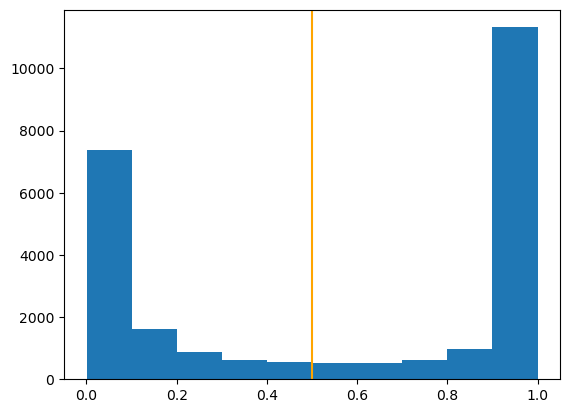

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'94.05'